In [34]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as  k
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageFont, ImageDraw

In [15]:
def create_pairs(x,digit_indices):
    
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [26]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

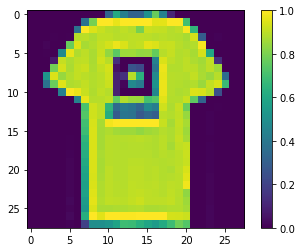

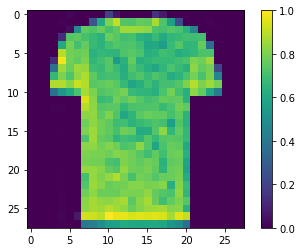

1.0


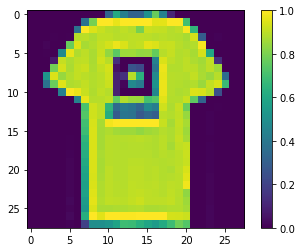

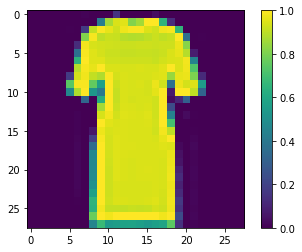

0.0


In [21]:
# array index
this_pair = 20

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])# array index
this_pair = 21

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

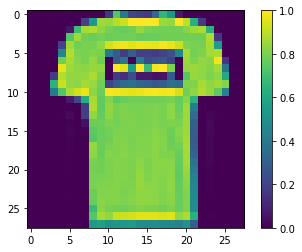

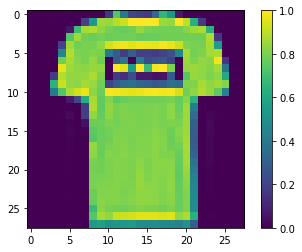

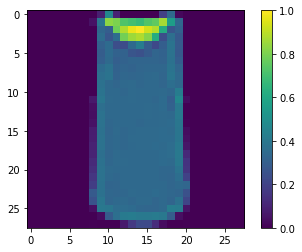

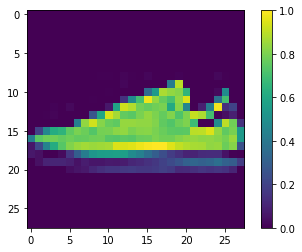

In [28]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

## Build Model

In [39]:
def initialize_base_network():
    input_base=Input(shape=(28,28),name='base_inout')
    x=Flatten(name='Flatten_input')(input_base)
    x=Dense(128,activation='relu',name='Dense1')(x)
    x=Dropout(0.1,name='Dropout_1')(x)
    x=Dense(128,activation='relu',name='Dense2')(x)
    return Model(inputs=input_base,outputs=x)

In [48]:
def euclidean_distance(vects):
    x,y=vects
    sum_square=k.sum(k.square(x-y),axis=1,keepdims=True)
    return k.sqrt(k.maximum(sum_square,k.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1,shape2=shapes
    return (shape1[0],1)

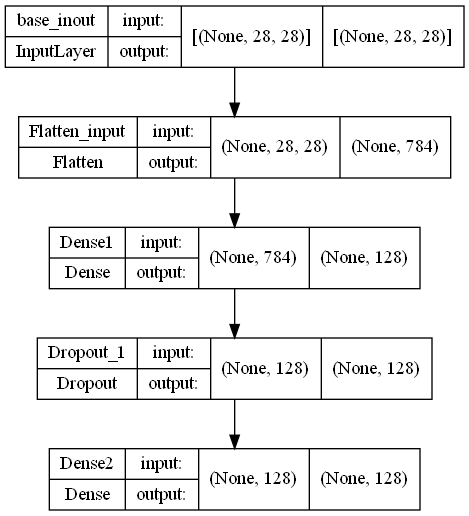

In [49]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

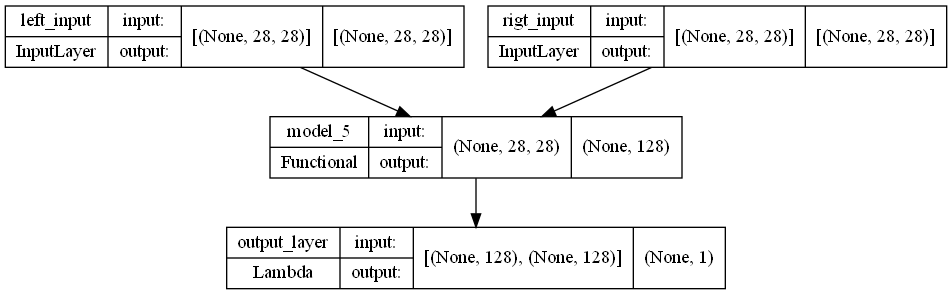

In [51]:
input_a=Input(shape=(28,28),name='left_input')
vect_output_a=base_network(input_a)
input_b=Input(shape=(28,28),name='rigt_input')
vect_output_b=base_network(input_b)

output=Lambda(euclidean_distance,name='output_layer',output_shape=eucl_dist_output_shape)([vect_output_a,vect_output_b])

model=Model([input_a,input_b],output)
# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [56]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred =k.square(y_pred)
        margin_square = k.square(k.maximum(margin - y_pred, 0))
        return k.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [57]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 3s 2ms/step - loss: 0.1234 - val_loss: 0.0936
Epoch 2/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0881 - val_loss: 0.0849
Epoch 3/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0814 - val_loss: 0.0792
Epoch 4/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0774 - val_loss: 0.0769
Epoch 5/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0749 - val_loss: 0.0774
Epoch 6/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0729 - val_loss: 0.0760
Epoch 7/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0713 - val_loss: 0.0769
Epoch 8/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0696 - val_loss: 0.0732
Epoch 9/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0687 - val_loss: 0.0737
Epoch 10/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0678 - val_loss: 0.0723

In [58]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 0s 612us/step - loss: 0.0742
Loss = 0.0742190033197403, Train Accuracy = 0.07631271878646441 Test Accuracy = 0.10065065065065065


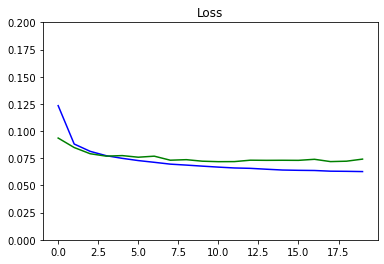

In [60]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

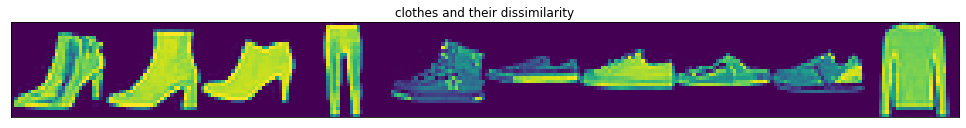

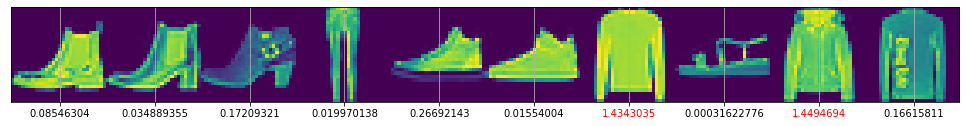

In [61]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)

## Huber Loss

In [62]:
# inputs
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)

# labels
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

In [63]:
# wrapper function that accepts the hyperparameter
def my_huber_loss_with_threshold(threshold):
  
    # function that accepts the ground truth and predictions
    def my_huber_loss(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
        
        return tf.where(is_small_error, small_error_loss, big_error_loss) 

    # return the inner function tuned by the hyperparameter
    return my_huber_loss

In [65]:
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss=my_huber_loss_with_threshold(threshold=1.2))
model.fit(xs, ys, epochs=500,verbose=0)
print(model.predict([10.0]))

[[18.826948]]


In [71]:
from tensorflow.keras.losses import Loss
class HuberLoss(Loss):
    
    def __init__(self,threshold=1):
        super().__init__()
        self.threshold=threshold
    def call(self,y_true,y_pred):
        error=y_true-y_pred
        is_small_error=tf.abs(error)<=self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)

In [76]:
moode=tf.keras.Sequential([tf.keras.layers.Dense(1,input_shape=[1])])
model.compile(optimizer='sgd',loss=HuberLoss(threshold=1.02))
model.fit(xs,ys,epochs=500,verbose=1)

Epoch 1/500
1/1 [==============================] - 0s 184ms/step - loss: 3.2687e-10
Epoch 2/500
1/1 [==============================] - 0s 997us/step - loss: 3.2271e-10
Epoch 3/500
1/1 [==============================] - 0s 2ms/step - loss: 3.1979e-10
Epoch 4/500
1/1 [==============================] - 0s 3ms/step - loss: 3.1630e-10
Epoch 5/500
1/1 [==============================] - 0s 2ms/step - loss: 3.1347e-10
Epoch 6/500
1/1 [==============================] - 0s 2ms/step - loss: 3.0943e-10
Epoch 7/500
1/1 [==============================] - 0s 2ms/step - loss: 3.0600e-10
Epoch 8/500
1/1 [==============================] - 0s 998us/step - loss: 3.0315e-10
Epoch 9/500
1/1 [==============================] - 0s 2ms/step - loss: 2.9975e-10
Epoch 10/500
1/1 [==============================] - 0s 2ms/step - loss: 2.9577e-10
Epoch 11/500
1/1 [==============================] - 0s 2ms/step - loss: 2.9297e-10
Epoch 12/500
1/1 [==============================] - 0s 2ms/step - loss: 2.8963e-10
Epoch 1

1/1 [==============================] - 0s 2ms/step - loss: 1.2306e-10
Epoch 100/500
1/1 [==============================] - 0s 998us/step - loss: 1.2222e-10
Epoch 101/500
1/1 [==============================] - 0s 2ms/step - loss: 1.2020e-10
Epoch 102/500
1/1 [==============================] - 0s 2ms/step - loss: 1.1851e-10
Epoch 103/500
1/1 [==============================] - 0s 2ms/step - loss: 1.1847e-10
Epoch 104/500
1/1 [==============================] - 0s 2ms/step - loss: 1.1637e-10
Epoch 105/500
1/1 [==============================] - 0s 2ms/step - loss: 1.1465e-10
Epoch 106/500
1/1 [==============================] - 0s 2ms/step - loss: 1.1375e-10
Epoch 107/500
1/1 [==============================] - 0s 2ms/step - loss: 1.1359e-10
Epoch 108/500
1/1 [==============================] - 0s 2ms/step - loss: 1.1061e-10
Epoch 109/500
1/1 [==============================] - 0s 2ms/step - loss: 1.0974e-10
Epoch 110/500
1/1 [==============================] - 0s 2ms/step - loss: 1.0911e-10
Epoc

1/1 [==============================] - 0s 2ms/step - loss: 5.8109e-11
Epoch 197/500
1/1 [==============================] - 0s 995us/step - loss: 5.7824e-11
Epoch 198/500
1/1 [==============================] - 0s 2ms/step - loss: 5.7513e-11
Epoch 199/500
1/1 [==============================] - 0s 2ms/step - loss: 5.6451e-11
Epoch 200/500
1/1 [==============================] - 0s 997us/step - loss: 5.6177e-11
Epoch 201/500
1/1 [==============================] - 0s 997us/step - loss: 5.6041e-11
Epoch 202/500
1/1 [==============================] - 0s 2ms/step - loss: 5.5125e-11
Epoch 203/500
1/1 [==============================] - 0s 2ms/step - loss: 5.5297e-11
Epoch 204/500
1/1 [==============================] - 0s 2ms/step - loss: 5.4856e-11
Epoch 205/500
1/1 [==============================] - 0s 3ms/step - loss: 5.3651e-11
Epoch 206/500
1/1 [==============================] - 0s 2ms/step - loss: 5.2624e-11
Epoch 207/500
1/1 [==============================] - 0s 998us/step - loss: 5.2325e-1

Epoch 293/500
1/1 [==============================] - 0s 998us/step - loss: 2.2279e-11
Epoch 294/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 295/500
1/1 [==============================] - 0s 998us/step - loss: 2.2146e-11
Epoch 296/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 297/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 298/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 299/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 300/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 301/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 302/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 303/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 304/500
1/1 [==============================] - 0s 2ms/step - loss:

Epoch 390/500
1/1 [==============================] - 0s 997us/step - loss: 2.2146e-11
Epoch 391/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 392/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 393/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 394/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 395/500
1/1 [==============================] - 0s 997us/step - loss: 2.2146e-11
Epoch 396/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 397/500
1/1 [==============================] - 0s 997us/step - loss: 2.2146e-11
Epoch 398/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 399/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 400/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 401/500
1/1 [==============================] - 0s 997us/step - l

1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 488/500
1/1 [==============================] - 0s 997us/step - loss: 2.2146e-11
Epoch 489/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 490/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 491/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 492/500
1/1 [==============================] - 0s 997us/step - loss: 2.2146e-11
Epoch 493/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 494/500
1/1 [==============================] - 0s 998us/step - loss: 2.2146e-11
Epoch 495/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 496/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 497/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
Epoch 498/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2146e-11
